In [2]:
# Lets import the nescessary libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# For plotting
import matplotlib.pyplot as plt

# Dataset download

We will be using the MNIST dataset to perform the studies. Since this is a famous dataset and often used as benchmark for many deep learning models, we can easily get it from the PyTorch datasets class.

To load the datasets, and get them in a suitable state for trainig, we will use PyTorch built in classes `datasets` and `DataLoader`.

The `datasets.MNIST` will fetch the data from the internet, and will already perform some transformations on the data. Transformations applied in this stage are the ones composed in the `transform` object. They are `ransforms.ToTensor()` which transforms our data in pyTorch tensors and `transforms.Normalize((0.5,), (0.5,))` which normalizes our data (pxel values) to `(x-0.5)/0.5)` mean 0 and std 1.

The `DataLoader` is responsable to `shuffle` and divide our training and test data into `batches` given the `batch_size` parameter. It can also paralelize the process, with the `Num_workers`, which tells the data loader instance how many sub-processes to use for data loading. This is a efficient and simple way to prepare your data for training.

The train_loader carries two objects, data and targets (data, targets = train_loader). The targets carries the 'True' numbers, out training labels.

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Lets not normalize it to make some tests!
batch_size = 32
trainset = datasets.MNIST(root='./data/', train=True, download=False, transform=transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=5)

testset = datasets.MNIST(root='./data/', train=False, download=False, transform=transform)
test_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=5)

## Plotting

To get a felling of the dataset, lets plot some of the downloaded images

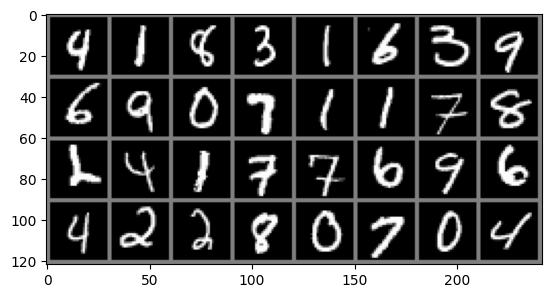

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

## Convolutional neural networks

Now that we fetched our dataset, separated it into training and test we can define out model to perform the training. 

The task here is to train a CNN to perform the classification of the images into their respective numbers. If we input a 9 we want it to classify it as a 9. 

As we saw in the lectures, CNN's are suitable candidates to be used in such task. We will use PyTprch built in 2d convolutions to build our model.

Our model is based in two dimensional convolutional operations `(nn.Conv2d)`, 2d max pooling `(max_pool2d)` and linear layers `nn.Linear` togheterher with relu layers `F.relu`.

`max_pool2d`: Applies a 2D max pooling over an input signal composed of several input planes.

`nn.Conv2d`: Applies a 2D convolution over an input signal composed of several input planes.

`nn.Linear`: Applies a linear transformation to the incoming data.

The MNIST dataset has only one color, and hence 1 channel. The size of the tensor (train or test) parsed to the CNN
will have a (n_batches,1,28,28) as the images has a size of 28x28. If a image is composed of more colors, it is commons for it to have more channels. But we will only work with one for today.

Once the tensor (n_batches,1,28,28) is inputed, a `nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)` will act upon it. It will results in a (n_batches,32,24,24) tensor. Remenber that if a image is mxm and a Kernel with size n acts upon it, the resulting size will be (m-n+1)x(m-n+1).

After the convolution, a `F.max_pool2d(input,kernel_size=2)` will be applied on top of the `(n_batches,32,24,24)`, resulting in a `(n_batches,32,12,12)`. Also, remenber that a MaxPool operation is diferent than a convolution, and teh former expression does not hold here even for equal kernel_sizes. If a MaxPull the size is simple cut to half.

After that we have again a `nn.Conv2d` and a `F.max_pool2d`. After the convlutions and max pull, the array `x` will be flattened and feed into a MLP for the final processing.

In [15]:
# Define a simple CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=256, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(input=self.conv1(x),kernel_size=2))
        x = F.relu(F.max_pool2d(input=self.conv2(x), kernel_size=2))
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In the pastblock we defined our network based on 2d convolutions and at the end linear layers. Note that we also defined theforward method, which is needed in order for pytorch to perform the training.

Now that we have our model, we can define our training loop and optimize the weights of our model for our given task.

In [16]:
# If GPUs are avaliable, lets use them!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()


Now that the optimizer, loss and devices are set up, we can begin the training.

In [17]:
for epoch in range(1, 2):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    # For each epoch lets also keep track of the loss in the test dataset
    # At this stage, we turn off the gradients calculations, to ensure that the model does not update its weights
    # And to make these calculations faster
    with torch.no_grad():
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target).mean()
            
            # Besides the loss, lets look at another metric, the accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
            # lets do it for only one batch, a thousand events is enough
            break
        accuracy = 100. * correct/1000
    
    print(f'Epoch {epoch}, Train Loss: {loss:.4f}', f' Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch 1, Train Loss: 0.1874  Test Loss: 0.0930, Accuracy: 96.70%
Epoch 2, Train Loss: 0.0175  Test Loss: 0.0604, Accuracy: 98.50%
Epoch 3, Train Loss: 0.0069  Test Loss: 0.0544, Accuracy: 98.10%
Epoch 4, Train Loss: 0.0038  Test Loss: 0.0463, Accuracy: 98.30%


The accuracy in the test datset should be of around 99%, which is a awesome results, the network predicts the correct values 99% of the time!

You can play with the parameters and try to get better results if you want to. Try to change the parameters of the CNN such as the first conv layer has 32 out channels and the second has 64. And make the maths to get the correct dimensions.

## Residual Neural network

What if we want to make the model more expressive, and better. One way would be to keep inscreasing the model size, with more parameters and more layers, as in theory, the bigger the model the more expressive it could be.

But, we usually run into technical problems when trying to make the model with more layers. One of them is the gradient vanishing problem, with dificults the training of the first set of layers in our model. Also, overfitting.

One way to bypass it is to use skip connections, like in the residual neural networks. Which is one of the ways to make out model more expressive.

Lets implement the residual blocks in our model and check if it improves the performance!

Here some more advanced techniques will be used:

`nn.BatchNorm2d`: Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs with additional channel dimension) (https://arxiv.org/abs/1502.03167)

Here also new parameters of the `nn.Conv2d` appear. They are the `stride`, `padding` and `bias`. I will explaing them in a second.

Remenber that when I was explaining the CNN model, we saw that convolution operations make the size of the output image smaller than the original one.

Since we typically use small kernels, for any given convolution we might only lose a few pixels but this can add up as we apply many successive convolutional layers. One straightforward solution to this problem is to add extra pixels of filler around the boundary of our input image, thus increasing the effective size of the image.

When computing the cross-correlation, we start with the convolution window at the upper-left corner of the input tensor, and then slide it over all locations both down and to the right. In the previous examples, we defaulted to sliding one element at a time. However, sometimes, either for computational efficiency or because we wish to downsample, we move our window more than one element at a time, skipping the intermediate locations. This is particularly useful if the convolution kernel is large since it captures a large area of the underlying image.

We refer to the number of rows and columns traversed per slide as stride. So far, we have used strides of 1, both for height and width. Sometimes, we may want to use a larger stride.

We also have a `self.shortcut`, which is essential in a Residual neural network. It is responsible for the x = f(x)+x of a neural network. In this case the shortcut() is a nn.Sequential(). The initialization self.shortcut = nn.Sequential() serves as a placeholder that does nothing by default. It's used when the input and output of the residual block have the same dimensions, allowing for a direct element-wise addition.

Take out the `nn.Sequential()` and the case when they have diferent dimensions! It will make things simpler!

We also have this: nn.AdaptiveAvgPool2d(). You can see a more detailed explanation here: https://stackoverflow.com/questions/58692476/what-is-adaptive-average-pooling-and-how-does-it-work/58694174#58694174



In [31]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        """
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        """

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [48]:
# Redefine the CNN model to use Residual Blocks
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        # Since the kernel size is 3, and we add one pixel at each side m = m -k + 1 + 2*padding = m! 
        # We conserve the dimensions of the image
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = ResidualBlock(in_channels=16, out_channels=16, stride=1)
        self.layer2 = ResidualBlock(in_channels=16, out_channels=16, stride=1)
        self.layer3 = ResidualBlock(in_channels=16, out_channels=16, stride=1)

        # Now lets make a operation to decrease the size of the outputs
        self.global_avg_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = nn.Linear(4*4*16, 128)  # Adjusted: 64 channels, global pooling reduces spatial dims to 1x1
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #print(x.size())
        out = F.relu(self.bn1(self.conv1(x)))
        
        # Now the residual blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        # Now the rest of the convolution beauty!
        out = self.global_avg_pool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)  # Flatten
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return F.log_softmax(out, dim=1)
        

Now that we defined the ResNet we can go back and train our model again!

In [ ]:
# lets load the new model
model = ResNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# And use the same training loop
for epoch in range(1, 5):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        #print(data.size())
        #print(target.size())
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    # For each epoch lets also keep track of the loss in the test dataset
    # At this stage, we turn off the gradients calculations, to ensure that the model does not update its weights
    # And to make these calculations faster
    with torch.no_grad():
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target).mean()
            
            # Besides the loss, lets look at another metric, the accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
            # lets do it for only one batch, a thousand events is enough
            break
        accuracy = 100. * correct/1000
    
    print(f'Epoch {epoch}, Train Loss: {loss:.4f}', f' Test Loss: {test_loss:.4f}, Test accuracy: {accuracy:.2f}%')

Epoch 1, Train Loss: 0.0661  Test Loss: 0.0588, Test accuracy: 98.30%
Epoch 2, Train Loss: 0.0750  Test Loss: 0.0422, Test accuracy: 98.30%
